In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [1]:
import cv2

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
ds=tf.data.Dataset.list_files('/content/drive/MyDrive/images/*.png',shuffle=False)
ds = ds.map(load_image)
ds = ds.map(lambda x: tf.image.resize(x, (32,32)))
ds = ds.map(lambda x: (x-127.5)/127.5)

In [10]:
len(ds)

80

In [11]:
ds_copy=ds

In [14]:
#lets do some duplication and concatinate to make varietyo of images
while(len(ds)<=60000):

  ds = ds.concatenate(ds_copy)


In [15]:
len(ds)

60080

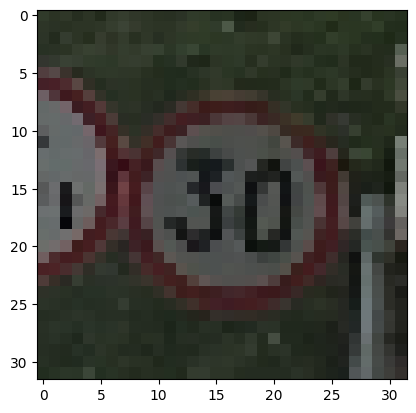

In [16]:
for elements in ds.take(1):
    plt.imshow((elements+1)/2)
    #print(elements.shape)

In [17]:
batch_size=128
ds = ds.shuffle(60000)
ds = ds.batch(batch_size)
ds = ds.prefetch(8)

### building the model

In [42]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,Input,BatchNormalization,MaxPooling2D,GlobalAveragePooling2D,Activation,Conv2DTranspose

In [19]:
def build_generator():
    model = Sequential()

    n_nodes = 128 * 8 * 8
    model.add(Input((100,)))
    model.add(Dense(n_nodes))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (8,8), activation='tanh', padding='same'))
    return model

In [20]:
generator=build_generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8192)                │         827,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 3)           │          24,579 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,376,515 (5.25 MB)

 Trainable params: 1,376,515 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
img = generator.predict(np.random.randn(4,100,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


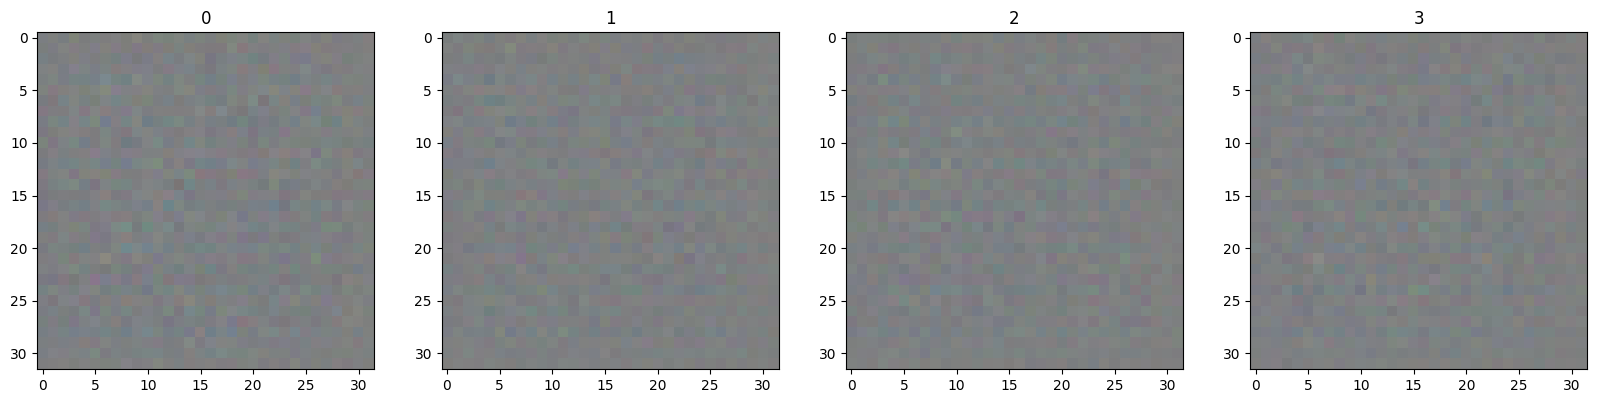

In [22]:
img = generator.predict(np.random.randn(4,100,1))

def rescale(img):
    img=img+1/2
    return img

img=rescale(img)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

# Building a discriminator model

In [23]:
def build_discriminator(in_shape=(32,32,3)):
      model = Sequential()
      model.add(Input((in_shape)))

      model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #16x16x128
      model.add(LeakyReLU(alpha=0.2))

      model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
      model.add(LeakyReLU(alpha=0.2))

      model.add(Flatten()) #shape of 8192
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid')) #shape of 1

      return model

In [24]:
discriminator=build_discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,361 (622.50 KB)

 Trainable params: 159,361 (622.50 KB)

 Non-trainable params: 0 (0.00 B)

## loss and optimizers

In [25]:
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [26]:
g_opt = Adam(0.0002,0.5)
d_opt = Adam(0.0002,0.5)
#0.0002,0.5


### losses

In [27]:
def discriminator_loss(real_output, fake_output):
    bce = BinaryCrossentropy(from_logits=True)

    #noise_real = 0.15*tf.random.uniform(tf.shape(real_output))
    #noise_fake = -0.15*tf.random.uniform(tf.shape(fake_output))



    real_labels = tf.ones_like(real_output)
    fake_labels = tf.zeros_like(fake_output)

    real_loss = bce(real_labels, real_output)
    fake_loss = bce(fake_labels, fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

In [28]:
def generator_loss(fake_output):
    bce = BinaryCrossentropy(from_logits=True)
    t_loss = bce(tf.ones_like(fake_output), fake_output)
    return t_loss

In [29]:
g_loss=generator_loss
d_loss=discriminator_loss

### model subclassing

In [30]:
from tensorflow.keras.models import Model
noise_dim=100


In [31]:
class trafficgan(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self,images):
        noise=tf.random.normal([batch_size,noise_dim])
        with tf.GradientTape() as d_tape:
            gen_images=self.generator(noise,training=False)
            fake_output=self.discriminator(gen_images,training=True)
            real_output=self.discriminator(images,training=True)
            disc_loss=self.d_loss(real_output,fake_output)

        dgrad = d_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


        with tf.GradientTape() as g_tape:
              gen_images=self.generator(noise,training=True)
              fake_output=self.discriminator(gen_images,training=False)
              gen_loss=self.g_loss(fake_output)

        ggrad = g_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"discriminator_loss":disc_loss, "generator_loss":gen_loss}









In [32]:
traffic=trafficgan(generator,discriminator)

In [33]:
traffic.compile(g_opt,d_opt,g_loss,d_loss)

In [34]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [35]:
class ModelMonitor(Callback):
    def __init__(self, num_img=1, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):

        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images = generated_images.numpy().astype(np.uint8)
        for i in range(self.num_img):
            img = generated_images[i]

            # Save image using cv2.imwrite
            save_path = f'/content/drive/My Drive/modelimagesone/generated_img_{epoch}_{i}.png'
            cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [36]:
hist = traffic.fit(ds, epochs=10,callbacks=[ModelMonitor()])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


470/470 ━━━━━━━━━━━━━━━━━━━━ 236s 94ms/step - discriminator_loss: 0.9455 - generator_loss: 1.3132
Epoch 2/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 217s 87ms/step - discriminator_loss: 1.0320 - generator_loss: 1.1151
Epoch 3/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 260s 88ms/step - discriminator_loss: 1.0636 - generator_loss: 0.9778
Epoch 4/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 224s 87ms/step - discriminator_loss: 0.8775 - generator_loss: 1.1869
Epoch 5/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 262s 89ms/step - discriminator_loss: 0.7228 - generator_loss: 1.4457
Epoch 6/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 219s 87ms/step - discriminator_loss: 0.6605 - generator_loss: 1.6065
Epoch 7/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 213s 87ms/step - discriminator_loss: 0.6049 - generator_loss: 1.7367
Epoch 8/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 214s 88ms/step - discriminator_loss: 0.5527 - generator_loss: 1.8857
Epoch 9/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 220s 88ms/step - discriminator_loss: 0.5103 - generator_loss: 2.0252
Epoch 10/10
470/470 ━━━━━━━━━━

In [37]:
imgs = generator.predict(tf.random.normal((16, 100, 1)))
imgs.shape


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


(16, 32, 32, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


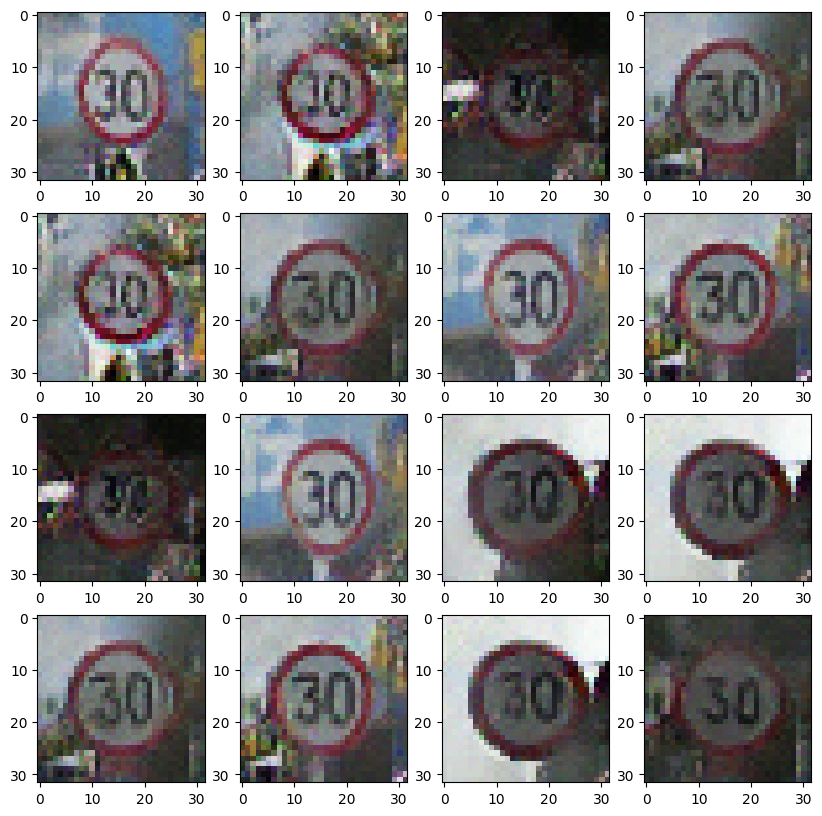

In [38]:
imgs = generator.predict(tf.random.normal((16, 100, 1)))

def rescale_images(images):
    return (images + 1) / 2  # Rescale from [-1, 1] to [0, 1]


img_rescaled = rescale_images(imgs)

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(img_rescaled[(r+1)*(c+1)-1])
plt.savefig('/content/drive/My Drive/generated_grid.png')

In [39]:
save_path = '/content/drive/My Drive/generatorofthirty.h5'

# Save the model
generator.save(save_path)

In [40]:
save_path = '/content/drive/My Drive/generatorofthirty.keras'

# Save the model
generator.save(save_path)

In [ ]:
# Save the entire model to a HDF5 file
discriminator.save('discriminatormodelone.h5')

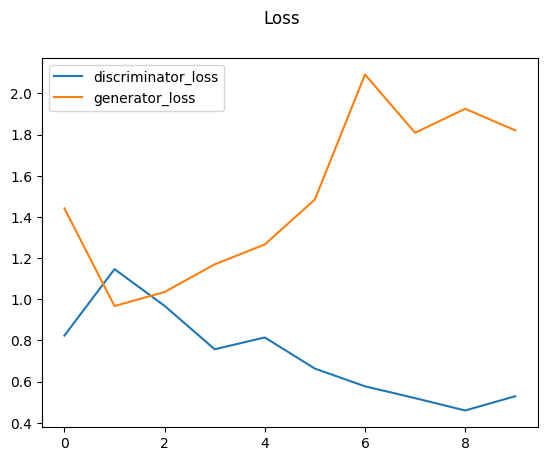

In [41]:
plt.suptitle('Loss')
plt.plot(hist.history['discriminator_loss'], label='discriminator_loss')
plt.plot(hist.history['generator_loss'], label='generator_loss')
plt.legend()
plt.show()